In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rubin_sim.utils import calcSeason, ddf_locations
from make_ddf_survey import optimize_ddf_times

In [2]:
ddfs = ddf_locations()
data_file='ddf_grid.npz'
ddf_data = np.load(data_file)
ddf_grid = ddf_data['ddf_grid'].copy()

season_frac=0.18
sequence_limit=286
airmass_limit = 2.1

sun_limit=-18
sky_limit=18. #21.75


In [21]:
ddf_name = 'EDFS_a'
mjds = optimize_ddf_times(ddf_name, ddfs[ddf_name][0], ddf_grid,
                                  season_frac=season_frac,
                                  sequence_limit=sequence_limit,
                         airmass_limit=airmass_limit, sky_limit=sky_limit)

Text(0, 0.5, '5-sigma depth, g (mags)')

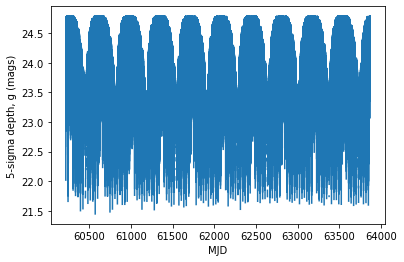

In [22]:
plt.plot(ddf_grid['mjd'], ddf_grid['%s_m5_g' % ddf_name])
plt.xlabel('MJD')
plt.ylabel('5-sigma depth, g (mags)')

(22.5, 25.0)

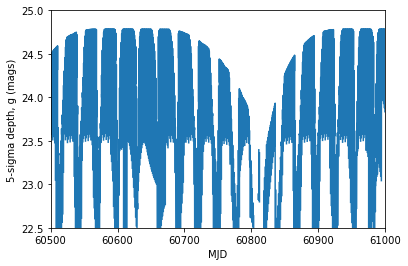

In [23]:
plt.plot(ddf_grid['mjd'], ddf_grid['%s_m5_g' % ddf_name])
plt.xlabel('MJD')
plt.ylabel('5-sigma depth, g (mags)')
plt.xlim([60500, 61000])
plt.ylim([22.5,25])

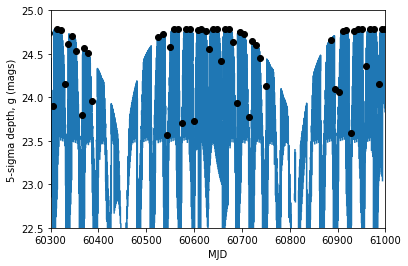

In [24]:
plt.plot(ddf_grid['mjd'], ddf_grid['%s_m5_g' % ddf_name])
plt.xlabel('MJD')
plt.ylabel('5-sigma depth, g (mags)')
plt.xlim([60300, 61000])
plt.ylim([22.5,25])

_temp, indx1, indx2 = np.intersect1d(mjds, ddf_grid['mjd'], return_indices=True)
plt.plot(mjds, ddf_grid['%s_m5_g' % ddf_name][indx2], 'ko')

(15.0, 25.0)

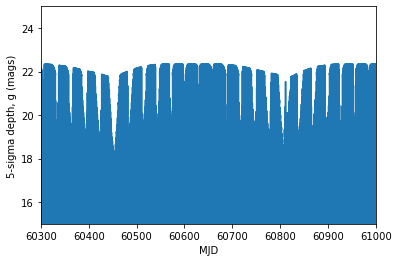

In [25]:
plt.plot(ddf_grid['mjd'], ddf_grid['%s_sky_g' % ddf_name])
plt.xlabel('MJD')
plt.ylabel('5-sigma depth, g (mags)')
plt.xlim([60300, 61000])
plt.ylim([15,25])

In [26]:
ddf_grid.dtype

dtype([('mjd', '<f8'), ('sun_alt', '<f8'), ('ELAISS1_airmass', '<f8'), ('ELAISS1_sky_g', '<f8'), ('ELAISS1_m5_g', '<f8'), ('XMM_LSS_airmass', '<f8'), ('XMM_LSS_sky_g', '<f8'), ('XMM_LSS_m5_g', '<f8'), ('ECDFS_airmass', '<f8'), ('ECDFS_sky_g', '<f8'), ('ECDFS_m5_g', '<f8'), ('COSMOS_airmass', '<f8'), ('COSMOS_sky_g', '<f8'), ('COSMOS_m5_g', '<f8'), ('EDFS_a_airmass', '<f8'), ('EDFS_a_sky_g', '<f8'), ('EDFS_a_m5_g', '<f8'), ('EDFS_b_airmass', '<f8'), ('EDFS_b_sky_g', '<f8'), ('EDFS_b_m5_g', '<f8')])

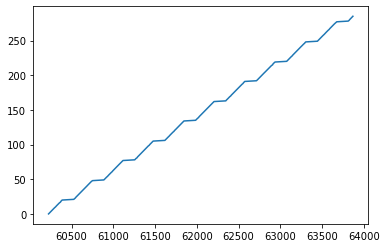

In [27]:
plt.plot(mjds, np.arange(np.size(mjds)))

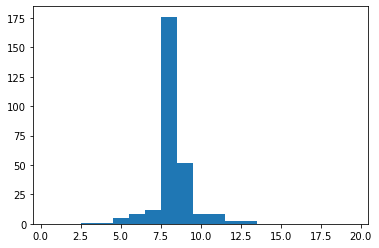

In [28]:
_tmp = plt.hist(np.diff(mjds), np.arange(20)+0.5)


In [11]:
sun_limit = np.radians(sun_limit)

ddf_RA = ddfs[ddf_name][0]

# XXX-- double check that I got this right
ack = ddf_grid['sun_alt'][0:-1] * ddf_grid['sun_alt'][1:]
night = np.zeros(ddf_grid.size, dtype=int)
night[np.where((ddf_grid['sun_alt'][1:] >= 0) & (ack < 0))] += 1
night = np.cumsum(night)
ngrid = ddf_grid['mjd'].size

# set a sun, airmass, sky masks
sun_mask = np.ones(ngrid, dtype=int)
sun_mask[np.where(ddf_grid['sun_alt'] >= sun_limit)] = 0

airmass_mask = np.ones(ngrid, dtype=int)
airmass_mask[np.where(ddf_grid['%s_airmass' % ddf_name] >= airmass_limit)] = 0

sky_mask = np.ones(ngrid, dtype=int)
sky_mask[np.where(ddf_grid['%s_sky_g' % ddf_name] <= sky_limit)] = 0
sky_mask[np.where(np.isnan(ddf_grid['%s_sky_g' % ddf_name]) == True)] = 0

m5_mask = np.zeros(ngrid, dtype=bool)
m5_mask[np.isfinite(ddf_grid['%s_m5_g' % ddf_name])] = 1

big_mask = sun_mask * airmass_mask * sky_mask * m5_mask

potential_nights = np.unique(night[np.where(big_mask > 0)])

# prevent a repeat sequence in a night
unights, indx = np.unique(night, return_index=True)
night_mjd = ddf_grid['mjd'][indx]
# The season of each night
night_season = calcSeason(ddf_RA, night_mjd)

raw_obs = np.ones(unights.size)
# take out the ones that are out of season
season_mod = night_season % 1

out_season = np.where((season_mod < season_frac) | (season_mod > (1.-season_frac)))
raw_obs[out_season] = 0
cumulative_desired = np.cumsum(raw_obs)
cumulative_desired = cumulative_desired/cumulative_desired.max()*sequence_limit

night_mask = unights*0
night_mask[potential_nights] = 1

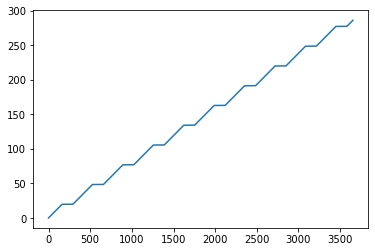

In [12]:
plt.plot(cumulative_desired)